In [154]:
import shap 
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split
import seaborn as sns

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
df = pd.read_pickle("/data/severs/clean_cancer_old.pkl")

In [26]:
train_index = pd.read_csv('/data/severs/trainind_patient_strat.csv')["Resample1"].values -1

In [25]:
train_index_diff = pd.read_csv('/data/severs/trainind_patient_strat_diffexp.csv')["Resample1"].values -1

In [83]:
# import patient numbers for differentially expressed cells
import csv
with open('/data/severs/BP_patientnumber_diffexp.csv', newline='') as f:
    reader = csv.reader(f)
    tmp = list(reader)
    
    patient_number = list()
    for line in tmp:
        sl = line[0].split("] ")[1].split(" ")
        for s in sl:
                patient_number.append(int(s))



In [9]:
df.head()

,FO538757.2,AP006222.2,RP11-206L10.9,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,HES4,...,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.4,AL354822.1,AC240274.1
Cell,,,,,,,,,,,,,,,,,,,,,
sc5rJUQ024_AAACCTGGTCTCCACT,-0.343108,-0.081219,-0.159213,-0.123929,-0.033997,0.061602,-0.290072,-0.098881,-0.095736,-0.005238,...,-3.776311,-1.423264,-1.318146,-0.477605,0.211917,-1.242434,-1.279868,-0.047263,-0.094151,0.027916
sc5rJUQ024_AAACGGGTCTCGTATT,-0.308522,-0.048712,-0.144592,-0.116811,-0.023424,0.119259,-0.258337,-0.089769,-0.097750,0.052328,...,0.303585,0.213102,0.374316,-3.442380,0.575263,-1.190086,0.776465,-0.029479,-0.078131,0.093447
sc5rJUQ024_AAAGCAAAGTGCGTGA,-0.309317,-0.053282,-0.144680,-0.116397,-0.024488,0.107756,-0.259811,-0.089825,-0.098724,0.045888,...,-0.990821,-1.011876,-0.898612,-3.438422,-2.650741,-1.191080,-0.858349,-0.032684,-0.078794,0.084099
sc5rJUQ024_AACGTTGGTTCAGCGC,-0.305403,-0.047272,-0.143177,-0.115943,-0.022791,0.120488,6.643475,-0.088888,-0.098330,0.055523,...,-0.529361,0.077009,-3.568859,-3.434878,-2.647959,-1.185283,-3.458560,-0.028966,-0.076801,0.096297
sc5rJUQ024_AACTCAGAGCCAGGAT,-0.295972,-0.040686,-0.139042,-0.113658,-0.020397,0.130144,-0.247556,-0.086311,-0.099487,0.068171,...,-3.684442,-3.559101,-3.551395,-3.415309,-2.630391,-1.170883,-0.402687,-0.025783,-0.072609,0.109493


In [101]:
Y = df.ESR1

In [11]:
X = df.drop("ESR1", axis=1)

In [126]:
df_diff = df.loc[abs(Y)>0.5]

In [127]:
df_diff["patient_number"] = patient_number


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


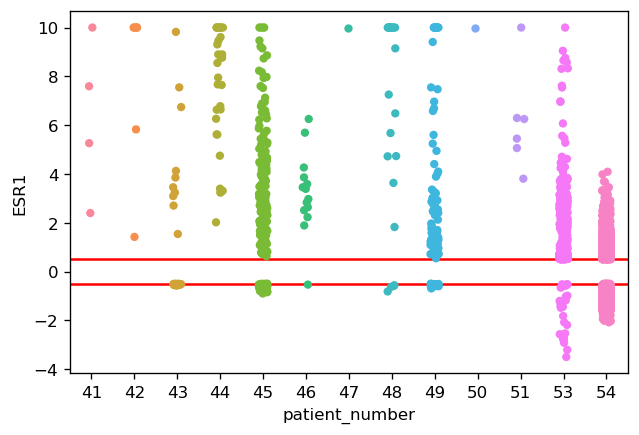

In [135]:
fig, ax = plt.subplots(figsize=(6,4), dpi=120)

sns.stripplot(x = df_diff.sort_values("ESR1").patient_number, y= df_diff.sort_values("ESR1").ESR1, s=5, c=df_diff.sort_values("ESR1").patient_number, edgecolor="black")
plt.axhline(y=0.5, color='r', linestyle='-')
plt.axhline(y=-0.5, color='r', linestyle='-')
plt.show()

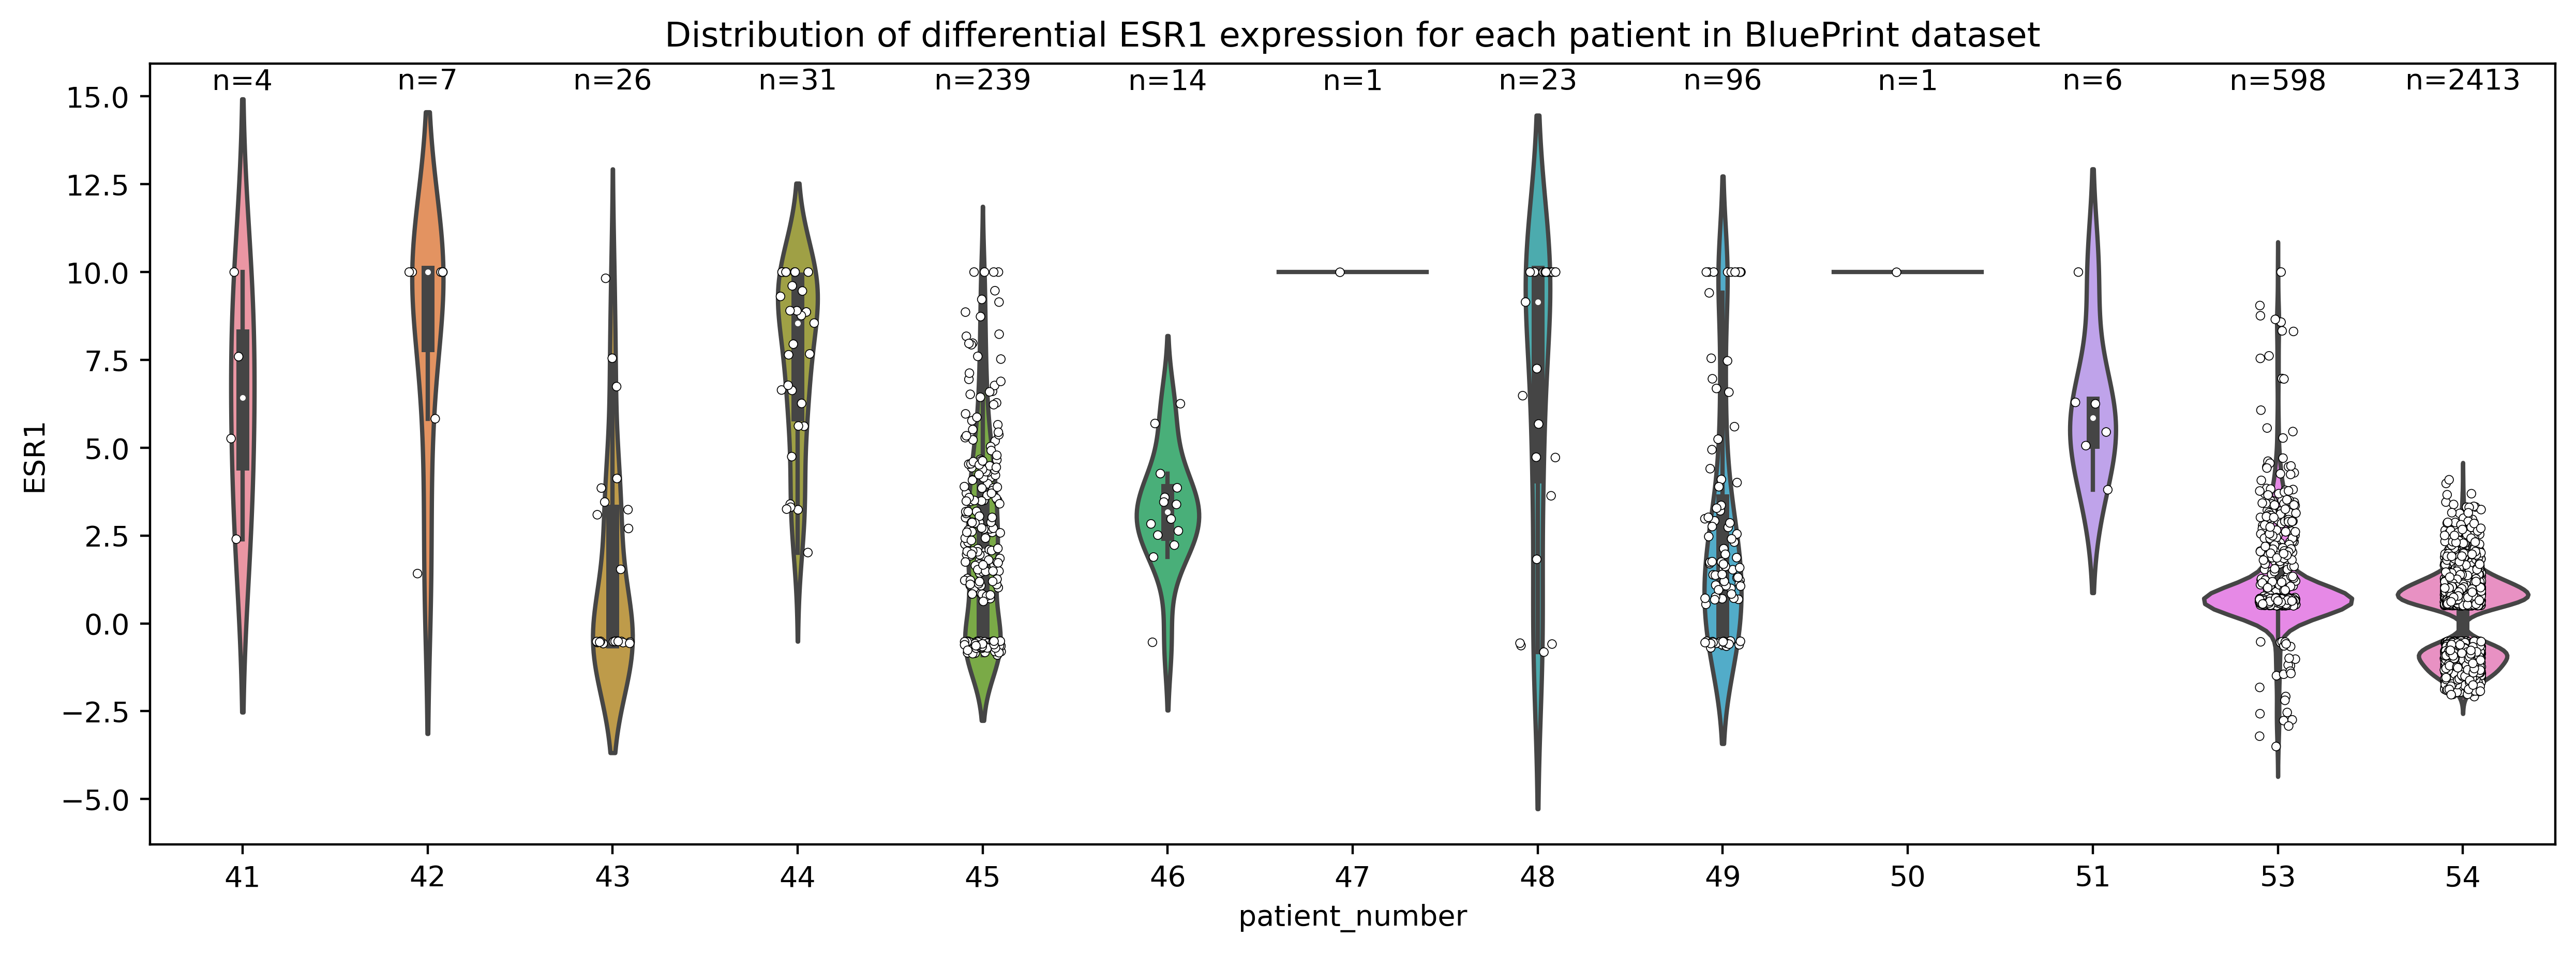

In [124]:
fig, ax = plt.subplots(1,1, dpi=400, figsize=(15,5))
ax = sns.violinplot(x="patient_number", y="ESR1", data=df_diff)
ax.set_xlabel("Patient number")
ax.set_ylabel("ESR1 Expression")
ax.set_title("Distribution of differential ESR1 expression for each patient in BluePrint dataset")
ax = sns.stripplot(data=df_diff, x='patient_number', y='ESR1',
                   color=("white"), edgecolor="black", linewidth=0.3, ax=ax, s=3)

for pn in df_diff.patient_number.unique():
    n = df_diff.patient_number.value_counts()[pn]
    x = pn-41
    if x > 11:
        x -= 1
    plt.text(x, 15.2, f"n={n}",horizontalalignment='center')

In [90]:
d = dict()
for p in patient_number:
    if p in d.keys()
        d[p] += 1
    else:
        d[p]

In [307]:
patient_indices = {}
for p in np.unique(patient_number):
    patient_indices[p] = []
for i, p in enumerate(patient_number):
    patient_indices[p].append(i)

In [310]:
patient_indices[45]

203

<BarContainer object of 13 artists>

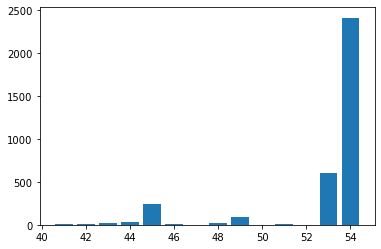

In [93]:
plt.bar(d.keys(), d.values())

In [137]:
x_train = X.loc[abs(Y)>0.5].iloc[train_index_diff]
y_train = Y[abs(Y)>0.5][train_index_diff]

In [31]:
np.random.seed(10)
seeds = np.random.randint(0, 100000, size=100)

In [33]:
params = {
        'eta' : 0.05, 
        'max_depth' : 6,
        'n_estimators':200,
        'subsample' : 0.8,
        'colsample_bytree' : 0.8,
        'eval_metric' :  'rmse',
        'n_jobs' : 40
}

In [85]:
kf = StratifiedKFold(5, shuffle=True)

In [86]:
kf.split(np.zeros(len(patient_number)), patient_number)

<generator object _BaseKFold.split at 0x7fece7367ac0>

In [152]:
shap_vals = np.empty((100, 14297))

In [331]:
np.random.seed(1051999)
for i in range(100):
    x_, _, y_, _ = train_test_split(x_train, y_train, test_size=0.2)
    model =  xgb.XGBRegressor(**params)
    model.fit(x_, y_)
    explainer = shap.TreeExplainer(model)
    loc_shap_vals = explainer.shap_values(x_)
    shap_vals[i] = np.abs(loc_shap_vals).mean(axis=0)

KeyboardInterrupt: 

In [205]:
shap.initjs()

In [225]:
sorted_shap.shape

(2214, 14297)

In [232]:
sorted_shap = loc_shap_vals[:, sorter[14277:]]

In [237]:
features = x_train.iloc[:, sorter[14277:]]

In [ ]:
mean_shap = shap_vals.mean(axis=0)

std_shap = shap_vals.std(axis=0)

In [ ]:
sorter = np.argsort(mean_shap)

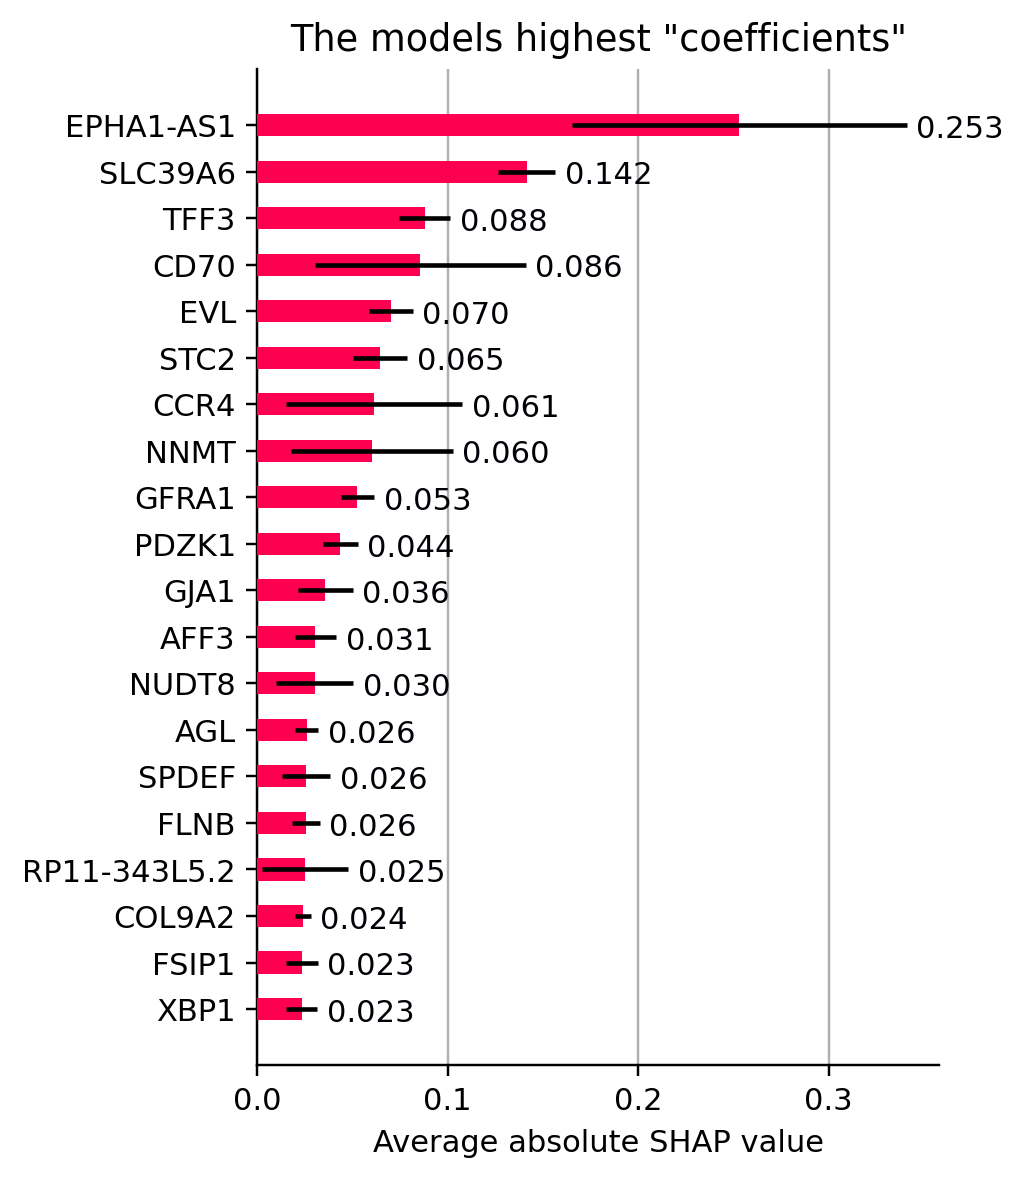

In [254]:
fig, ax = plt.subplots(figsize=(4,6), dpi=220)
ax.grid(zorder=0, axis="x")
ax.barh(np.linspace(0,40,20), mean_shap[sorter][-20:], align='center', height=1, color="#FF0051", xerr=std_shap[sorter][-20:], zorder=10)
ax.set_yticks(np.linspace(0,40,20))
ax.set_yticklabels(X.columns[sorter][-20:])
ax.set_xlabel("Average absolute SHAP value")
ax.set_title('The models highest "coefficients"')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i, v in enumerate(mean_shap[sorter][-20:]):
        ax.text(v + std_shap[sorter][-20:][i] + 0.005, np.linspace(0,40,20)[i]-0.55, f"{v:.3f}", color="#000006")
plt.savefig("/home/severs/SingleCells/plouts")

In [256]:
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.05, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=40, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [258]:
y_pred = model.predict(x_test)

NameError: name 'x_test' is not defined

## Correlations

In [267]:
corrs = {}
for col in X.columns:
    corrs[col]=(Y.corr(X[col]))

In [270]:
corrs["EPHA1-AS1"]

-0.0542424379893095

# Single model Shapley analysis

In [326]:
model =  xgb.XGBRegressor(**params)
model.fit(x_train, y_train)
explainer = shap.TreeExplainer(model)
loc_shap_vals = explainer.shap_values(x_)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


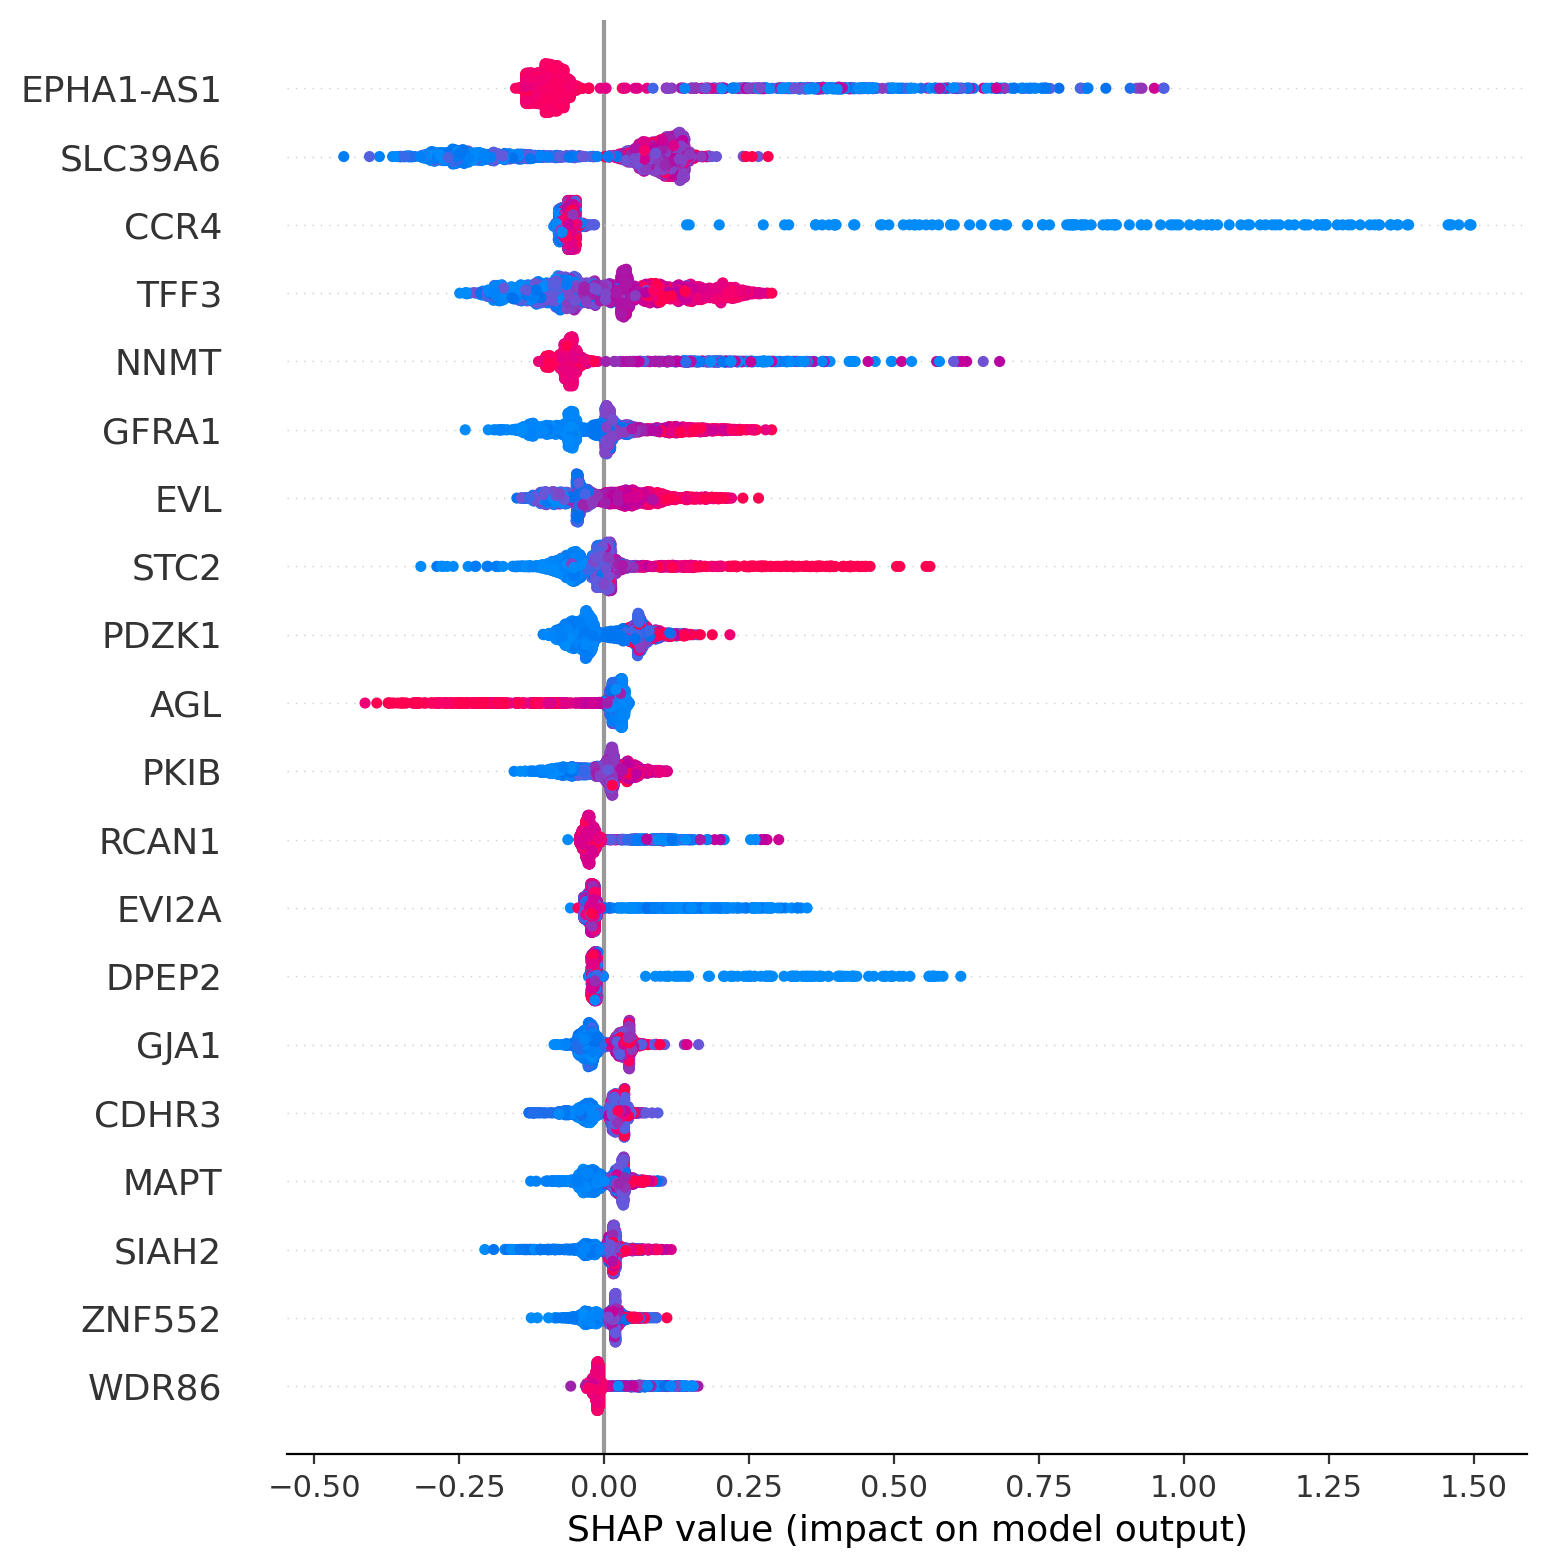

In [286]:
#explainer = shap.TreeExplainer(model)
#loc_shap_vals = explainer.shap_values(x_)
plt.figure(dpi=200)
shap.summary_plot(loc_shap_vals, x_, color_bar=False)

In [295]:
def get_index(gene : str, X=X : pd.DataFrame):
    return np.where(X.columns==gene)[0][0]

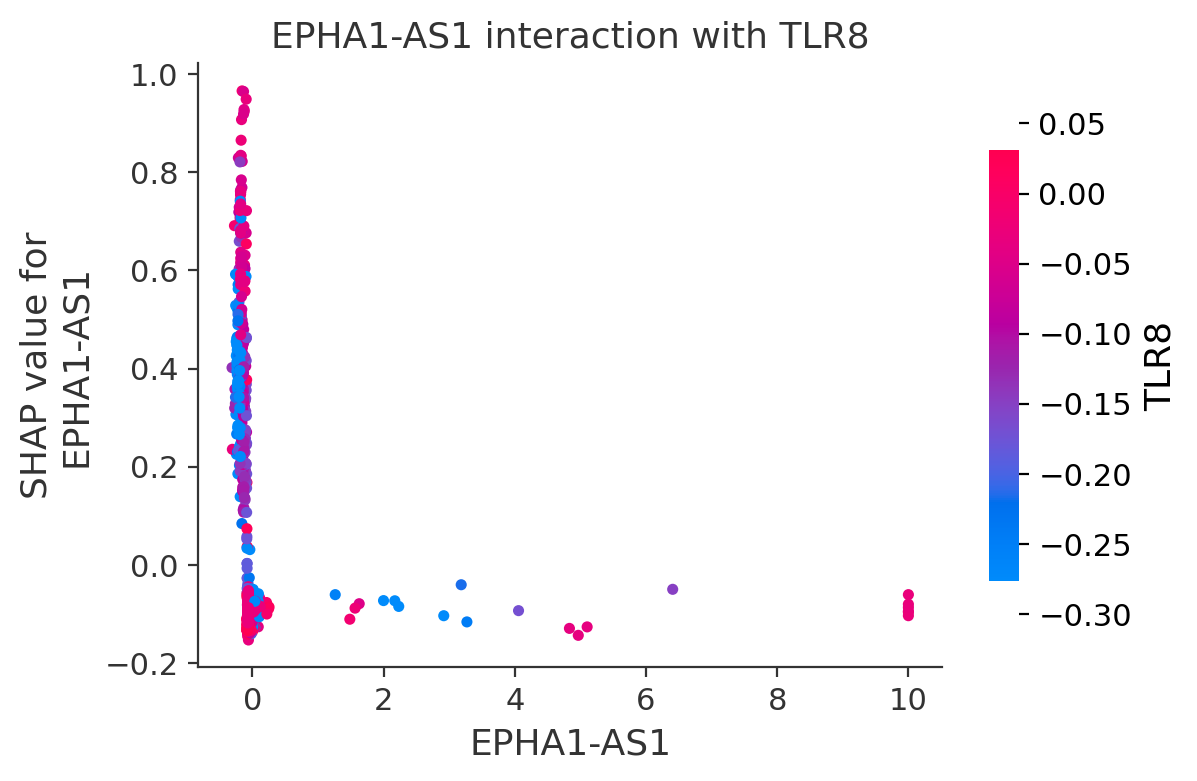

In [303]:
fig, ax = plt.subplots(dpi=200)
shap.dependence_plot(5722, 
                     shap_values=loc_shap_vals, 
                     features=x_, 
                     feature_names=X.columns, 
                     display_features=None, 
                     interaction_index=get_index("TLR8"), 
                     x_jitter=0, alpha=1, 
                     title="EPHA1-AS1 interaction with TLR8", xmin=None, xmax=None, ax=ax, show=True)


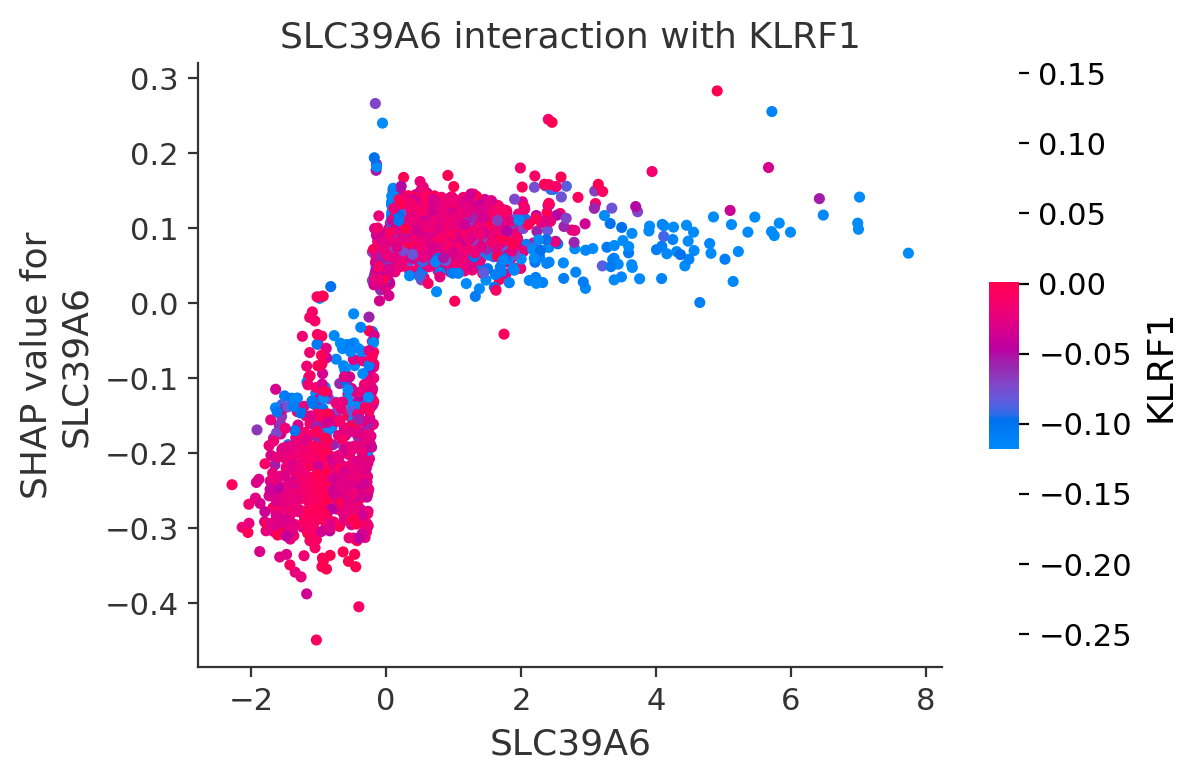

In [302]:
fig, ax = plt.subplots(dpi=200)
shap.dependence_plot(get_index("SLC39A6"), 
                     shap_values=loc_shap_vals, 
                     features=x_, 
                     feature_names=X.columns, 
                     display_features=None, 
                     interaction_index=get_index("KLRF1"), 
                     x_jitter=0, alpha=1, 
                     title="SLC39A6 interaction with KLRF1", xmin=None, xmax=None, ax=ax, show=True)

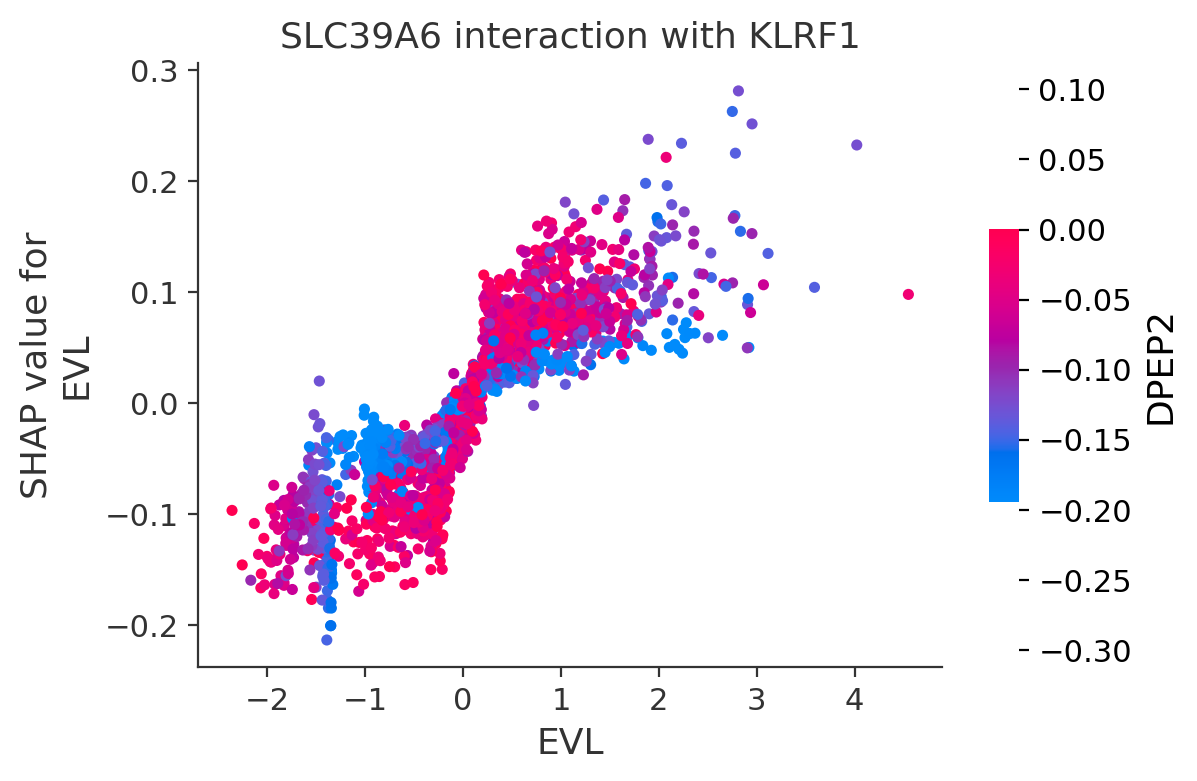

In [328]:
fig, ax = plt.subplots(dpi=200)
shap.dependence_plot(get_index("EVL"), 
                     shap_values=loc_shap_vals, 
                     features=x_, 
                     feature_names=X.columns, 
                     display_features=None, 
                     interaction_index="auto", 
                     x_jitter=0, alpha=1, 
                     title="SLC39A6 interaction with KLRF1", xmin=None, xmax=None, ax=ax, show=True)

# Patient Specific Shapley values

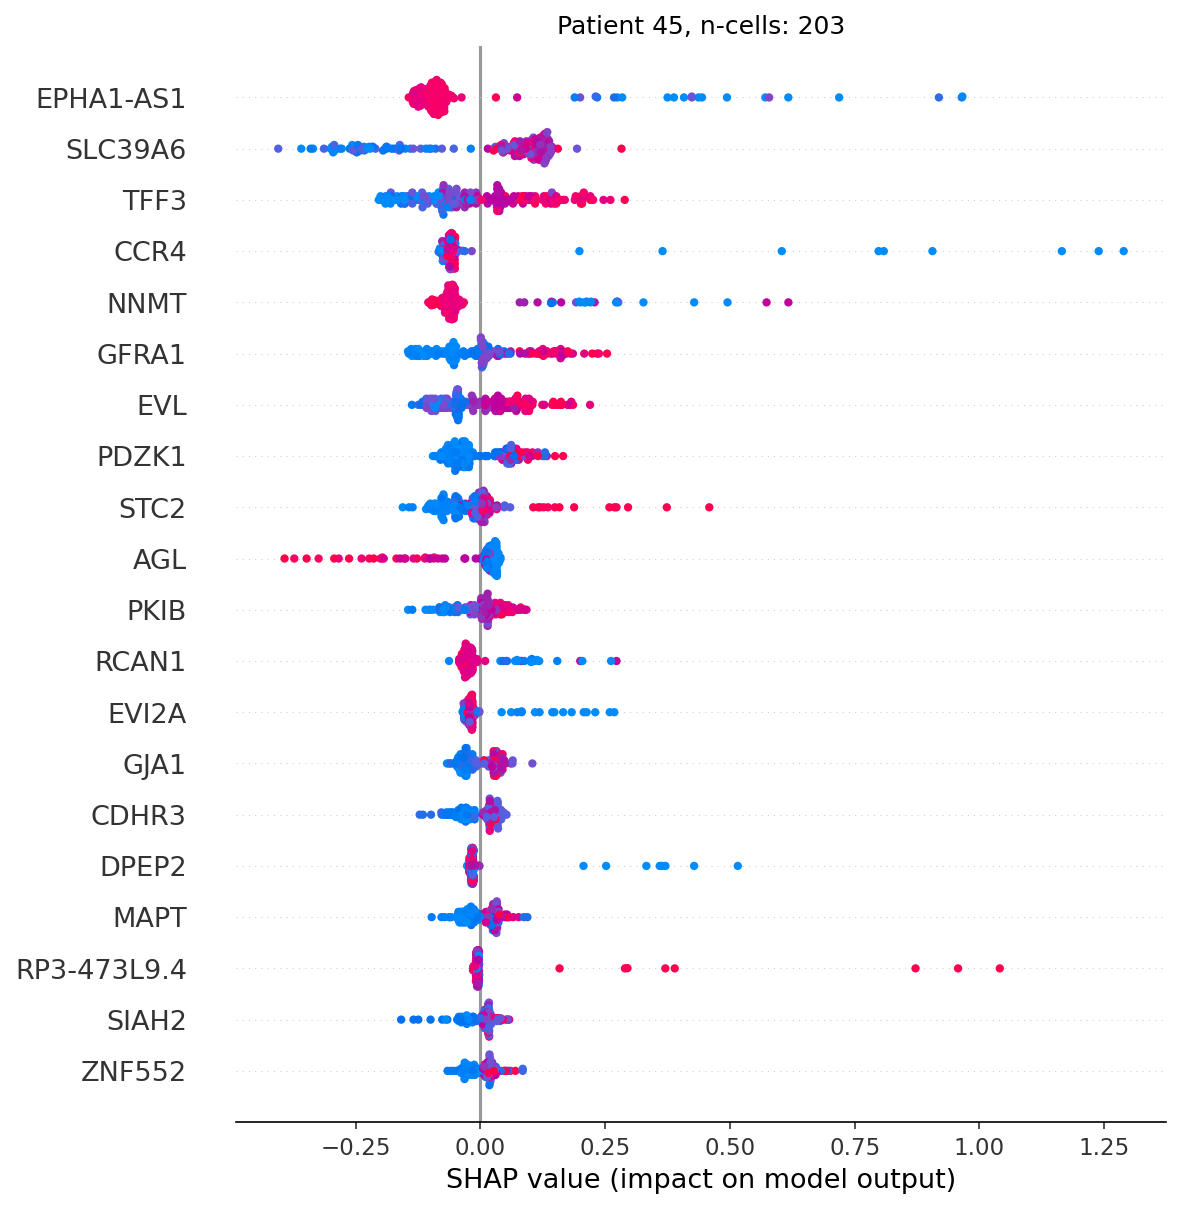

In [319]:
plt.figure(dpi=150)
plt.title(f"Patient 45, n-cells: {len(patient_indices[45])}")
shap.summary_plot(loc_shap_vals[patient_indices[45]], x_.iloc[patient_indices[45]],
                  color_bar=False)


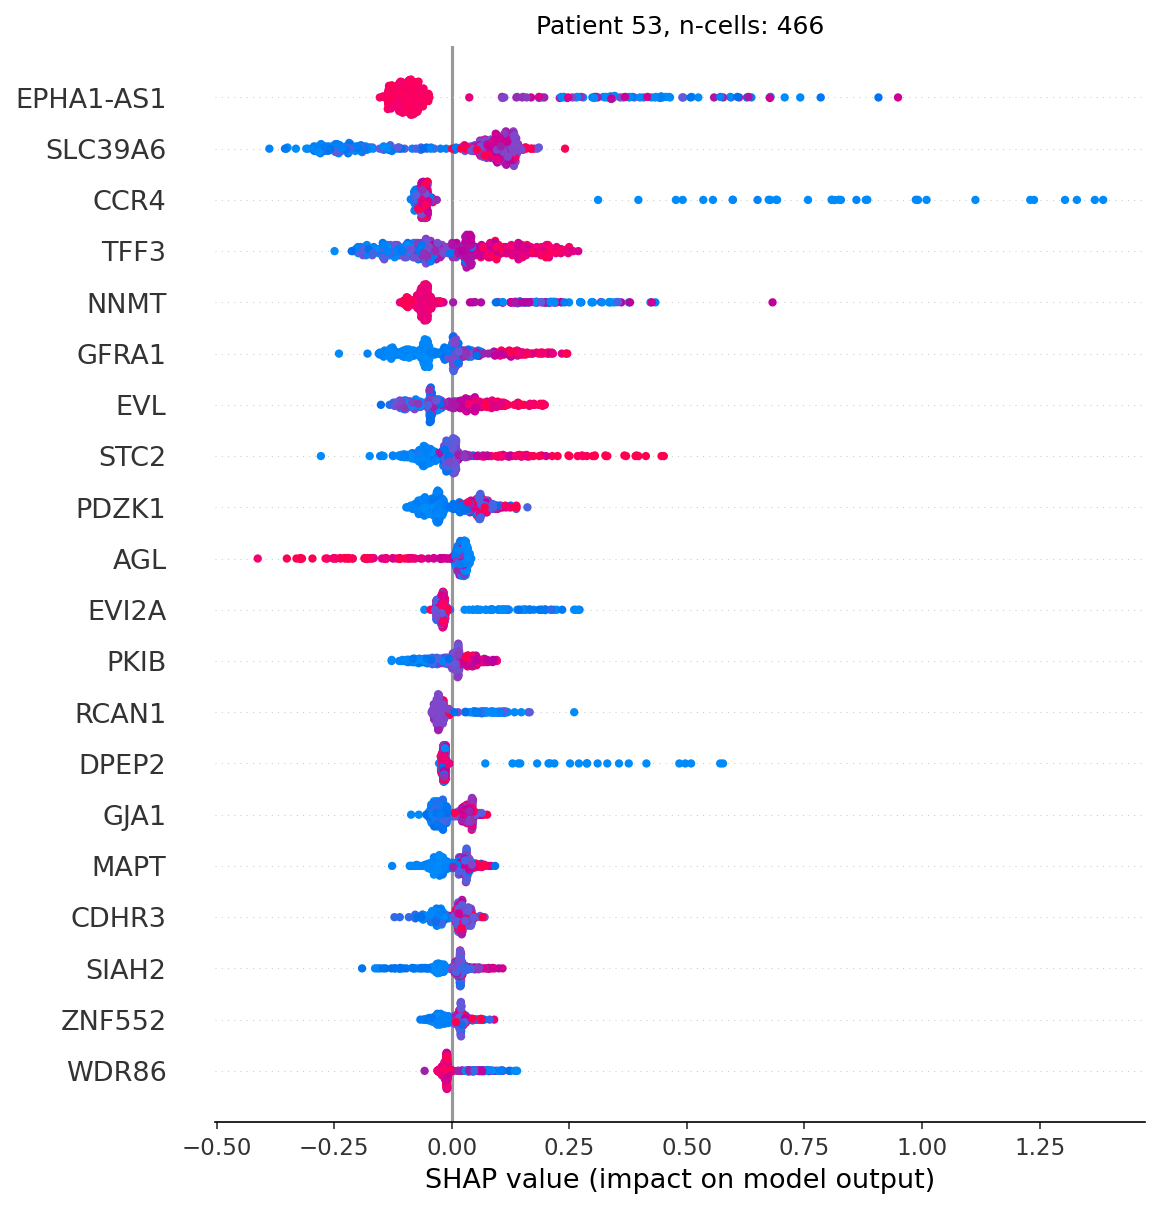

In [320]:
plt.figure(dpi=150)
p = 53
plt.title(f"Patient {p}, n-cells: {len(patient_indices[p])}")
shap.summary_plot(loc_shap_vals[patient_indices[p]], x_.iloc[patient_indices[p]],
                  color_bar=False)

In [323]:
loc_shap_vals.shape

(2214, 14297)

In [325]:
max(patient_indices[p])

2767

IndexError: index 2214 is out of bounds for axis 0 with size 2214

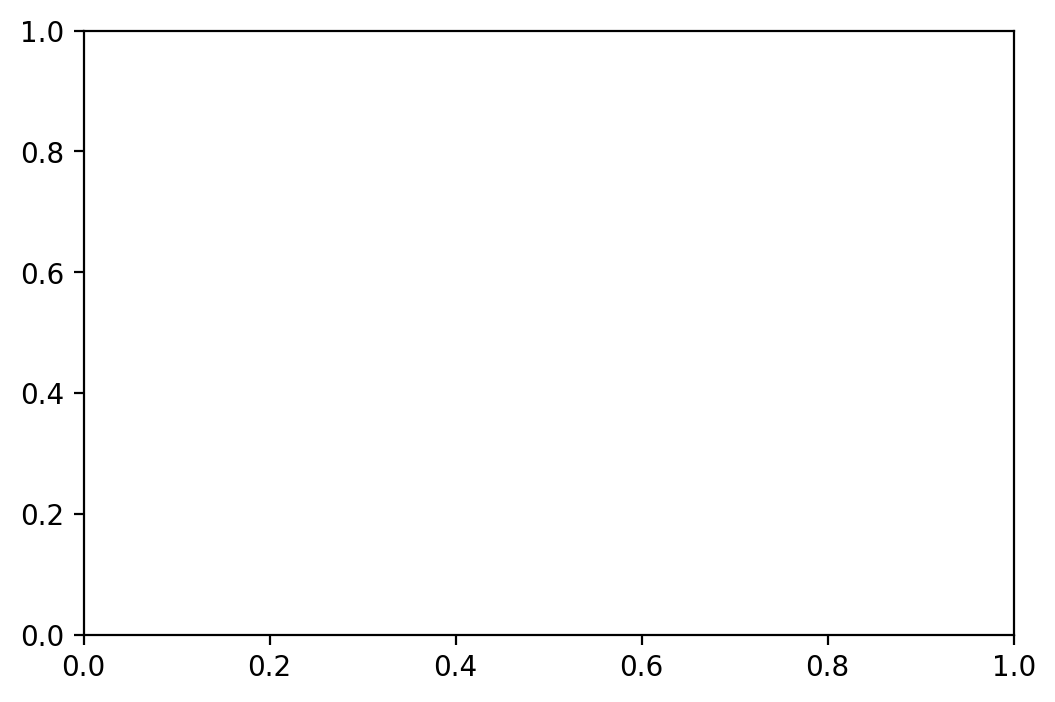

In [321]:
fig, ax = plt.subplots(dpi=200)
shap.dependence_plot(5722, 
                     shap_values=loc_shap_vals[patient_indices[p]], 
                     features=x_.iloc[patient_indices[p]], 
                     feature_names=X.columns, 
                     display_features=None, 
                     interaction_index=get_index("TLR8"), 
                     x_jitter=0, alpha=1, 
                     title="EPHA1-AS1 interaction with TLR8", xmin=None, xmax=None, ax=ax, show=True)

